# Cat or Non-Cat Classification
<sub><i>L-Layer Deep Neural Network (step by step) </i></sub>

## 1. Packages

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy
import h5py
import numpy as np
import os

## 2. Helper functions

### 2.1. Forward Functions

#### 2.1.1. Sigmoid Activation Function 
<img src="../../../img/sigmoid-activation-function.png" width="300">

In [50]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

#### 2.1.2. Tanh Activation Function 
<img src="../../../img/tanh-activation-function.jpg" width="300">

In [51]:
def tanh(Z):
    A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
    cache = Z
    return A, cache

#### 2.1.3. Relu Activation Function 
<img src="../../../img/relu-activation-function.png" width="300">

In [52]:
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

### 2.2 Backward Function

#### 2.2.1. Relu Backward Function

In [53]:
def relu_backward(dA, cache):
    Z = cache
    dZ = copy.deepcopy(dA)
    dZ[Z <= 0] = 0
    return dZ

#### 2.2.2. Sigmoid Backward Function

In [54]:
def sigmoid_backward(dA, cache):
    Z = cache
    A, _ = sigmoid(Z)
    dZ = dA * A * (1 - A)
    return dZ

#### 2.2.3. Tanh Backward Function

In [55]:
def tanh_backward(dA, cache):
    Z = cache
    A, _ = tanh(Z)
    dZ = dA * (1 - A**2)
    return dZ

## 3. Main functions

### 3.1. Initialize parameters

In [56]:
def initialize_parameters(layers_dims):
    ''' 
    initialize weights and bias for nn
    layers_dims: a list of size (quantity of units) of each layers. Example: [5, 4, 3, 2, 1]: 5 -> features X 
    return: dict of parameters
    '''
    np.random.seed(52)
    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        # degbug
        assert(parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layers_dims[l], 1))
    return parameters

### 3.2. Forward Propagation

#### 3.2.1. Linear Forward

In [57]:
def linear_forward(A_prev, W, b):
    Z = W @ A_prev + b 
    cache = (A_prev, W, b)
    return Z, cache

#### 3.2.2. Linear Activation Forward

In [58]:
def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == 'relu':
        A, activation_cache = relu(Z)
    elif activation == 'sigmoid':
        A, activation_cache = sigmoid(Z)
    elif activation == 'tanh':
        A, activation_cache = tanh(Z)
        
    cache = (linear_cache, activation_cache)
    return A, cache

#### 3.2.3. L-model Forward

In [82]:
def L_model_forward(X, parameters):
    caches = []
    A_prev = X
    L = len(parameters) // 2
    for l in range(L - 1): # (linear->relu) * (L-1) -> (linear->sigmoid)
        A_prev, cache = linear_activation_forward(A_prev, parameters['W' + str(l+1)], parameters['b' + str(l+1)], activation='relu')
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A_prev, parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')
    caches.append(cache)
    return AL, caches

### 3.3. Cost Computation

In [60]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    cost = np.squeeze(cost)
    return cost

### 3.4. Backward Propagation

#### 3.4.1. Linear Backward

In [61]:
def linear_backward(dZ, cache):
    m = dZ.shape[1]
    A_prev, W, b = cache
    
    dW = (1/m) * (dZ @ A_prev.T)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = W.T @ dZ
    return dW, db, dA_prev

#### 3.4.2. Linear Activation Backward

In [62]:
def linear_activation_backward(dA, cache, activation):
    (linear_cache, activation_cache) = cache
    if activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
    elif activation == 'tanh':
        dZ = tanh_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

#### 3.4.3. L-model Backward

In [84]:
def L_model_backward(AL, Y, caches):
    L = len(caches)
    m = Y.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    grads = {}
    
    dA_prev, dW, db = linear_activation_backward(dAL, caches[L-1], activation='sigmoid')
    grads['dW' + str(L)] = dW
    grads['db' + str(L)] = db
    
    for l in reversed(range(L - 1)):
        dA_prev, dW, db = linear_activation_backward(dA_prev, caches[l], activation='relu')
        grads['dW' + str(l + 1)] = dW
        grads['db' + str(l + 1)] = db
    return grads
    

### 3.5. Update Parameters

In [64]:
def update_parameters(parameters, grads, learning_rate=1e-3):
    params = copy.deepcopy(parameters)
    L = len(parameters) // 2
    for l in range (L):
        params["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)]
        params["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)]
    return params

## 4. Load & Process Data

### 4.1. Load Datatset

In [65]:
os.getcwd()

'/Users/minhquang/Documents/Learning/AI/DeepLearning/NeuralNetwork/ANN/cat_or_noncat'

In [66]:
# Relative path
train_file = '../../../../data/catvnoncat/train_catvnoncat.h5'
test_file = '../../../../data/catvnoncat/test_catvnoncat.h5'

# load train dataset
with h5py.File(train_file, 'r') as train_data:
    X_train_orig = np.array(train_data["train_set_x"][:])
    y_train = np.array(train_data["train_set_y"][:])

with h5py.File(test_file, 'r') as test_data:
    X_test_orig = np.array(test_data["test_set_x"][:])
    y_test = np.array(test_data["test_set_y"][:])

X_shape: (209, 64, 64, 3)
y_shape: (209,)


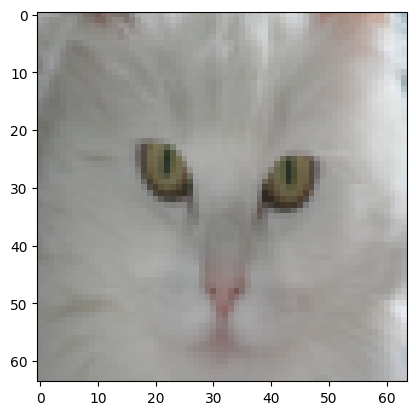

In [67]:
plt.imshow(X_train_orig[50])
print('X_shape:' ,X_train_orig.shape)
print('y_shape:',y_train.shape)

### 4.1.2. Process data

In [68]:
# normalize the data
X_train_standard = X_train_orig / 255.
X_test_standard = X_test_orig / 255. 
# flatten the data
X_train_flatten = X_train_standard.reshape(X_train_standard.shape[0], -1)
X_test_flatten = X_test_standard.reshape(X_test_standard.shape[0], -1)

In [69]:
print('X_train_flatten.shape:',X_train_flatten.shape)
print('X_test_flatten.shape:',X_test_flatten.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train_flatten.shape: (209, 12288)
X_test_flatten.shape: (50, 12288)
y_train: (209,)
y_test: (50,)


In [70]:
# reshape data to apply to model (nX features, m examples)
X_train = X_train_flatten.T
X_test = X_test_flatten.T

y_train = y_train.reshape(-1, 1).T 
y_test = y_test.reshape(-1, 1).T

In [71]:
print('X_train.shape:',X_train.shape)
print('X_test.shape:',X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train.shape: (12288, 209)
X_test.shape: (12288, 50)
y_train: (1, 209)
y_test: (1, 50)


## 5. Deep Neural Network Model

In [106]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, decay_rate=0.9):
    costs = []
    parameters = initialize_parameters(layers_dims)
    for i in range(num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if i % 100 == 0:
            learning_rate *= decay_rate
        
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print(f"Cost after iteration {i}: {np.squeeze(cost)}")
            costs.append(cost)
    
    return parameters, costs
def predict(X, parameters, threshold=0.5):
    AL, caches = L_model_forward(X, parameters)
    predictions = (AL > threshold)
    return predictions

def score(X, y, parameters):
    predictions = predict(X, parameters)
    accuracy = 100 * np.mean(predictions == y) 
    return accuracy

def plot_costs(costs):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iteration')
    plt.title("Cost Plot")
    plt.show()

## Training

In [107]:
layers_dims = [X_train.shape[0], 128, 64, 32, 16, 1]
parameters, costs = L_layer_model(X_train, y_train, num_iterations=1000, learning_rate=5, layers_dims=layers_dims, print_cost=True, decay_rate=0.9)
plot_costs(costs, learning_rate=0.1)

Cost after iteration 0: 0.6931470065008584
Cost after iteration 100: 0.6439736717222666
Cost after iteration 200: 0.6439736336193397
Cost after iteration 300: 0.6439735702225692
Cost after iteration 400: 0.6439734671631192
Cost after iteration 500: 0.6439733271264404
Cost after iteration 600: 0.6439731245355588
Cost after iteration 700: 0.6439728311705883
Cost after iteration 800: 0.6439723898200833
Cost after iteration 900: 0.6439716837317581
Cost after iteration 999: 0.6439705294006087


TypeError: plot_costs() got an unexpected keyword argument 'learning_rate'

In [104]:
score(X_train, y_train, parameters)

np.float64(65.55023923444976)